In [1]:
import torch
from torchvision import datasets

## Setting up Data

### Load data from `torchvision.datasets`

In [2]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

In [3]:
print(f"Train data length : {len(training_data)}, Test data length : {len(test_data)}")
type(training_data), type(test_data)


Train data length : 60000, Test data length : 10000


(torchvision.datasets.mnist.MNIST, torchvision.datasets.mnist.MNIST)

In [4]:
import os

NUM_WORKERS = os.cpu_count()

torch.set_num_threads(NUM_WORKERS)

NUM_WORKERS, torch.get_num_threads()

(16, 16)

In [5]:
classes = training_data.classes
classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

### Visualise Data

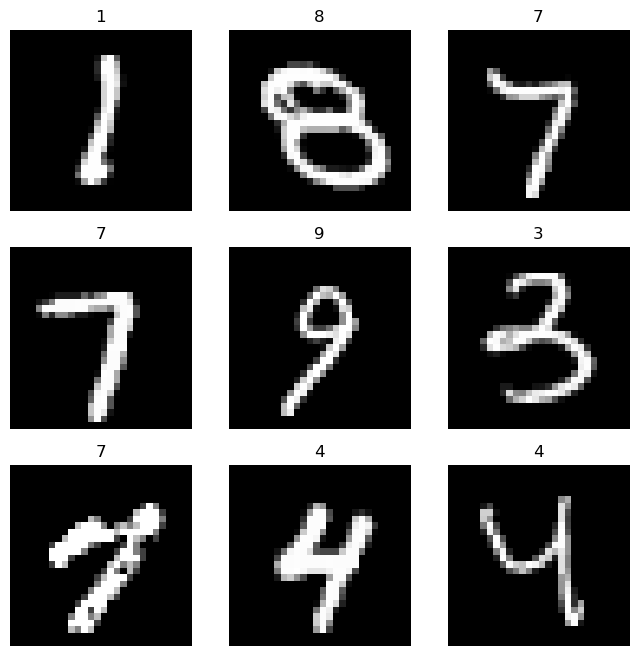

In [6]:
import matplotlib.pyplot as plt

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

### Convert to tensors and batches

In [7]:
from torch.utils.data import DataLoader

BATCH_SIZE = 128

train_loader = DataLoader(training_data,
                         batch_size=BATCH_SIZE,
                         num_workers=NUM_WORKERS,
                         shuffle=True)


test_loader = DataLoader(test_data,
                         batch_size=BATCH_SIZE*2,
                         num_workers=NUM_WORKERS)

train_loader, test_loader

(<torch.utils.data.dataloader.DataLoader at 0x27c2ac74b20>,
 <torch.utils.data.dataloader.DataLoader at 0x27c2ac75870>)

In [8]:
from collections import Counter

test_labels = [label for _, label in test_data]
print(f"Test Labels : {Counter(test_labels)}")

Test Labels : Counter({1: 1135, 2: 1032, 7: 1028, 3: 1010, 9: 1009, 4: 982, 0: 980, 8: 974, 6: 958, 5: 892})


In [9]:
image, label = next(iter(train_loader))

image[0].shape, label[0]

(torch.Size([1, 28, 28]), tensor(6))

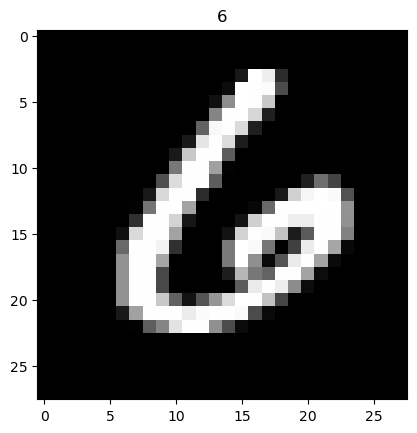

In [10]:
plt.imshow(image[0].squeeze(), cmap="gray")
plt.title(label[0].numpy())
plt.show()

## Train Model

### Device agnostic code 

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

### Model Structure

In [12]:
import torch.nn as nn

class MNISTmodelv0(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      padding=1,
                      stride=1),
            nn.BatchNorm2d(num_features=hidden_units,
                           momentum=0.1,
                           affine=True,
                           track_running_stats=True
                          ),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      padding=1,
                      stride=1),
            nn.BatchNorm2d(num_features=hidden_units,
                           momentum=0.1,
                           affine=True,
                           track_running_stats=True
                          ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      padding=1,
                      stride=1),
            nn.BatchNorm2d(num_features=hidden_units,
                           momentum=0.1,
                           affine=True,
                           track_running_stats=True
                          ),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      padding=1,
                      stride=1),
            nn.BatchNorm2d(num_features=hidden_units,
                           momentum=0.1,
                           affine=True,
                           track_running_stats=True
                          ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      padding=1,
                      stride=1),
            nn.BatchNorm2d(num_features=hidden_units,
                           momentum=0.1,
                           affine=True,
                           track_running_stats=True
                          ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units * 3 * 3,
                     out_features=output_shape)
        )
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        # print(f"Shape = {x.shape}")
        x = self.classifier(x)

        return x
        

In [13]:
torch.manual_seed(42)
model = MNISTmodelv0(input_shape=1,
                    hidden_units=10,
                    output_shape=len(classes))

model

MNISTmodelv0(
  (layer1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(10,

In [14]:
from torchinfo import summary
input_size, label = next(iter(train_loader))
# input_size.shape

summary(model, input_size=input_size.shape)

Layer (type:depth-idx)                   Output Shape              Param #
MNISTmodelv0                             [128, 10]                 --
├─Sequential: 1-1                        [128, 10, 14, 14]         --
│    └─Conv2d: 2-1                       [128, 10, 28, 28]         100
│    └─BatchNorm2d: 2-2                  [128, 10, 28, 28]         20
│    └─ReLU: 2-3                         [128, 10, 28, 28]         --
│    └─Conv2d: 2-4                       [128, 10, 28, 28]         910
│    └─BatchNorm2d: 2-5                  [128, 10, 28, 28]         20
│    └─ReLU: 2-6                         [128, 10, 28, 28]         --
│    └─MaxPool2d: 2-7                    [128, 10, 14, 14]         --
├─Sequential: 1-2                        [128, 10, 7, 7]           --
│    └─Conv2d: 2-8                       [128, 10, 14, 14]         910
│    └─BatchNorm2d: 2-9                  [128, 10, 14, 14]         20
│    └─ReLU: 2-10                        [128, 10, 14, 14]         --
│    └─Conv2

### Optimizer and Loss Function & Accuracy

In [15]:
from torchmetrics.classification import MulticlassAccuracy

LEARNING_RATE = 0.001

loss_fn = torch.nn.CrossEntropyLoss()
optimizer =  torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)
# accuracy_fn = MulticlassAccuracy(num_classes=len(classes))


def accuracy_fn(y_pred, y_true):
    correct = torch.eq(y_pred, y_true).sum().item()
    return correct

In [16]:
import os
os.cpu_count()

16

In [17]:
import chime
chime.theme = "sonic"

chime.success()

### Train Pass

In [18]:
%%time
from tqdm import tqdm
import chime

EPOCHS = 10
torch.manual_seed(42)
history_train, history_test = {'loss':[], 'accuracy':[]}, {'loss':[], 'accuracy':[]}

for epoch in range(EPOCHS):
    print(f"EPOCH : {epoch+1}/{EPOCHS}----------------------------------------------------")
    
    train_loss, train_acc = 0, 0
    test_loss, test_acc = 0, 0
    model.train()
    for batch, (X, y) in enumerate(tqdm(train_loader)):
         #--------------training-------------------------
        
        # put data on device  : GPU/CPU
        X_train, y_train = X.to(device), y.to(device)
        batch_size = X_train.size(0)
    
        # make prediction (get logits)
        y_logits = model(X_train).squeeze()
        
        # calculate loss
        loss = loss_fn(y_logits, y_train)
        train_loss += loss.item() * batch_size
    
        # turn logits into predictions for accuracy calculation
        y_pred = torch.argmax(y_logits, dim=1)
        accuracy = accuracy_fn(y_pred, y_train)
        train_acc += accuracy 
    
        # set all gradient to zero
        optimizer.zero_grad()
    
        # backpropagation
        loss.backward()
    
        # optimizer step: update the weights
        optimizer.step()

        #--------------testing-------------------------
    model.eval()
    with torch.no_grad():     # torch.inference_mode(): gives error if i have to use accuracy inside it
        for (X, y) in tqdm(test_loader):
    
            # do the prediction
            X_test, y_test = X.to(device), y.to(device)
            batch_size = X_test.size(0)
    
            # forward pass
            y_test_pred = model(X_test).squeeze()
            preds = torch.argmax(y_test_pred, dim=1)
    
            # loss & Accuracy
            loss= loss_fn(y_test_pred, y_test)
            test_loss += loss.item() * batch_size
    
            accuracy = accuracy_fn(preds, y_test)
            test_acc += accuracy 
    
    train_acc = (train_acc / len(train_loader.dataset)) * 100
    train_loss /= len(train_loader.dataset)
    test_acc = (test_acc / len(test_loader.dataset)) * 100
    test_loss /= len(test_loader.dataset)

    
    history_train["loss"].append(train_loss)
    history_train["accuracy"].append(train_acc)
    history_test["loss"].append(test_loss)
    history_test["accuracy"].append(test_acc)
    chime.success()
    
    print(f"    Train Loss: {train_loss:.4f}--|--Train Accuracy: {train_acc:.4f}--|--Test Loss: {test_loss:.4f}----|----Test Accuracy: {test_acc:.4f}")

EPOCH : 1/10----------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:23<00:00,  1.67it/s]


    Train Loss: 0.4020--|--Train Accuracy: 91.0600--|--Test Loss: 0.0991----|----Test Accuracy: 97.3100
EPOCH : 2/10----------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:23<00:00,  1.69it/s]


    Train Loss: 0.0790--|--Train Accuracy: 97.8217--|--Test Loss: 0.0602----|----Test Accuracy: 98.1400
EPOCH : 3/10----------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:23<00:00,  1.72it/s]


    Train Loss: 0.0550--|--Train Accuracy: 98.3783--|--Test Loss: 0.0478----|----Test Accuracy: 98.4800
EPOCH : 4/10----------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:25<00:00,  1.57it/s]


    Train Loss: 0.0452--|--Train Accuracy: 98.5967--|--Test Loss: 0.0499----|----Test Accuracy: 98.3400
EPOCH : 5/10----------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:25<00:00,  1.56it/s]


    Train Loss: 0.0377--|--Train Accuracy: 98.8733--|--Test Loss: 0.0431----|----Test Accuracy: 98.6800
EPOCH : 6/10----------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:25<00:00,  1.56it/s]


    Train Loss: 0.0342--|--Train Accuracy: 98.9350--|--Test Loss: 0.0498----|----Test Accuracy: 98.3800
EPOCH : 7/10----------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:25<00:00,  1.56it/s]


    Train Loss: 0.0306--|--Train Accuracy: 99.0433--|--Test Loss: 0.0333----|----Test Accuracy: 98.9000
EPOCH : 8/10----------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:25<00:00,  1.55it/s]


    Train Loss: 0.0275--|--Train Accuracy: 99.1400--|--Test Loss: 0.0322----|----Test Accuracy: 98.8800
EPOCH : 9/10----------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:26<00:00,  1.53it/s]


    Train Loss: 0.0260--|--Train Accuracy: 99.1950--|--Test Loss: 0.0360----|----Test Accuracy: 98.8600
EPOCH : 10/10----------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:25<00:00,  1.55it/s]

    Train Loss: 0.0233--|--Train Accuracy: 99.2650--|--Test Loss: 0.0288----|----Test Accuracy: 99.0100
CPU times: total: 34min 4s
Wall time: 16min 10s


In [19]:
checkpoint = {
    'epoch': EPOCHS,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss_fn,
    
    # Hyperparameters
    'batch_size': BATCH_SIZE,
    'learning_rate': LEARNING_RATE,
    'optimizer_name': 'Adam',
    'loss_fn_name': 'CrossEntropyLoss',
    
    # Model architecture info
    'model_class': 'MNISTmodelv0',
    'model_architecture': str(model),  
    
    #  history
    'history_train': history_train,
    'history_test': history_test,
}

torch.save(checkpoint, f'checkpoint_modelv2.pth')

In [20]:
checkpoint = torch.load('checkpoint_modelv2.pth')

C:\Users\Jaycp\AppData\Local\Temp\ipykernel_6852\671385409.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('checkpoint_modelv2.pth')


## Evaluation

### Check loss and accuracy

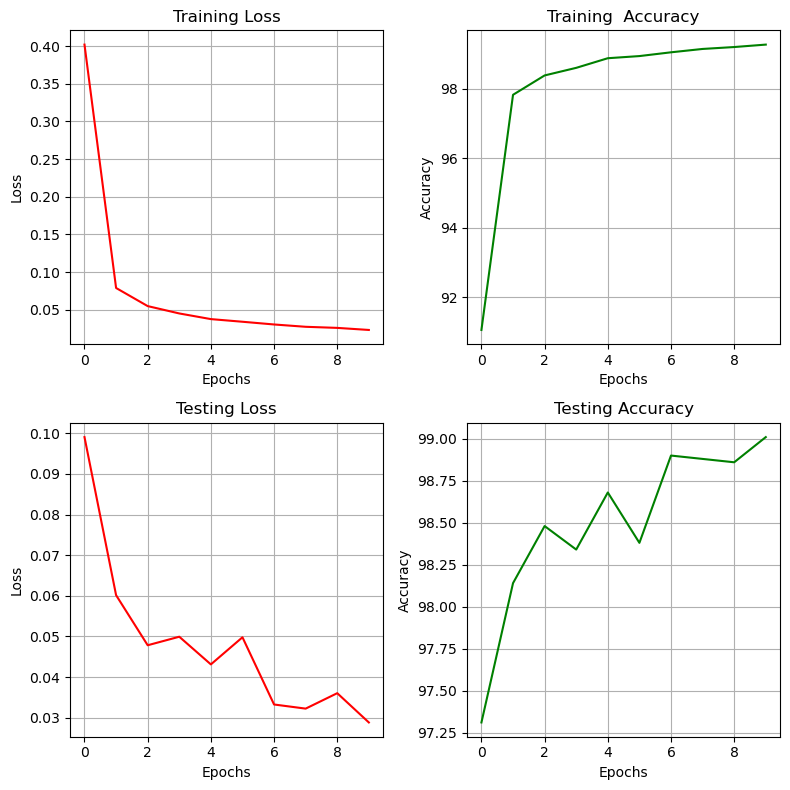

In [21]:
import matplotlib.pyplot as plt

hist_train, hist_test = checkpoint['history_train'], checkpoint['history_test']
epochs = checkpoint['epoch'] | EPOCHS

hist_train["loss"], type(hist_train["loss"])

fig, axs = plt.subplots(2, 2, figsize=(8, 8))

axs[0, 0].plot(range(epochs), hist_train["loss"], label="Loss", color="red")
axs[0, 0].set_title("Training Loss")
axs[0, 0].set_xlabel("Epochs")
axs[0, 0].set_ylabel("Loss")
axs[0, 0].grid(True)

axs[0, 1].plot(range(epochs), hist_train["accuracy"], label="Accuracy", color="green")
axs[0, 1].set_title("Training  Accuracy")
axs[0, 1].set_xlabel("Epochs")
axs[0, 1].set_ylabel("Accuracy")
axs[0, 1].grid(True)

axs[1, 0].plot(range(epochs), hist_test["loss"], label="Loss",  color="red")
axs[1, 0].set_title("Testing Loss")
axs[1, 0].set_xlabel("Epochs")
axs[1, 0].set_ylabel("Loss")
axs[1, 0].grid(True)

axs[1, 1].plot(range(epochs), hist_test["accuracy"], label="Accuracy",  color="green")
axs[1, 1].set_title("Testing Accuracy")
axs[1, 1].set_xlabel("Epochs")
axs[1, 1].set_ylabel("Accuracy")
axs[1, 1].grid(True)


fig.tight_layout()
plt.show()

### Check confusion Metrics

C:\Users\Jaycp\AppData\Local\Temp\ipykernel_6852\1771813096.py:60: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('model/checkpoints/model_checkpoint_

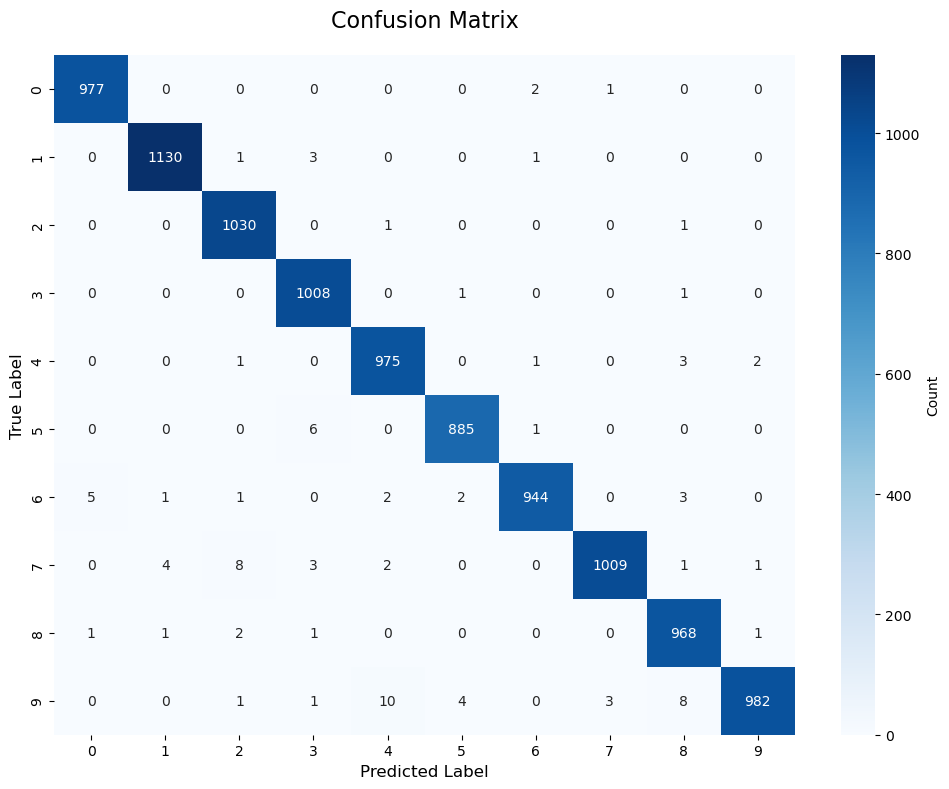


Classification Report:
              precision    recall  f1-score   support

           0     0.9939    0.9969    0.9954       980
           1     0.9947    0.9956    0.9952      1135
           2     0.9866    0.9981    0.9923      1032
           3     0.9863    0.9980    0.9921      1010
           4     0.9848    0.9929    0.9888       982
           5     0.9922    0.9922    0.9922       892
           6     0.9947    0.9854    0.9900       958
           7     0.9961    0.9815    0.9887      1028
           8     0.9827    0.9938    0.9883       974
           9     0.9959    0.9732    0.9845      1009

    accuracy                         0.9908     10000
   macro avg     0.9908    0.9908    0.9907     10000
weighted avg     0.9908    0.9908    0.9908     10000


Per-Class Accuracy:
Class 0: 99.69%
Class 1: 99.56%
Class 2: 99.81%
Class 3: 99.80%
Class 4: 99.29%
Class 5: 99.22%
Class 6: 98.54%
Class 7: 98.15%
Class 8: 99.38%
Class 9: 97.32%


In [22]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

def plot_confusion_matrix(model, test_loader, device, class_names=None):
    model.eval()
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            
            outputs = model(X)
            preds = torch.argmax(outputs, dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())
    
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    cm = confusion_matrix(all_labels, all_preds)
    
    if class_names is None:
        class_names = [str(i) for i in range(cm.shape[0])]
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, 
                yticklabels=class_names,
                cbar_kws={'label': 'Count'})
    
    plt.title('Confusion Matrix', fontsize=16, pad=20)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.show()

    
    print("\nClassification Report:")
    print("=" * 60)
    print(classification_report(all_labels, all_preds, 
                                target_names=class_names,
                                digits=4))
    
    # Print per-class accuracy
    print("\nPer-Class Accuracy:")
    print("=" * 60)
    class_accuracy = cm.diagonal() / cm.sum(axis=1)
    for i, acc in enumerate(class_accuracy):
        print(f"Class {class_names[i]}: {acc*100:.2f}%")
    
    return cm, all_preds, all_labels


checkpoint = torch.load('model/checkpoints/model_checkpoint_modelv2.pth')
model = MNISTmodelv0(1, 10, len(classes))  # Your model class
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)

class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
cm, predictions, labels = plot_confusion_matrix(model, test_loader, device, class_names)

### Check Predictions

In [23]:
import torch
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

def predict_image(image_path, model, device, class_names=None):

    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
        transforms.Resize((28, 28)),                   # Resize to 28x28
        transforms.ToTensor(),                         # Convert to tensor [0, 1]
    ])
    
    # Load and transform image
    image = Image.open(image_path)
    image_tensor = transform(image)
    
    # Add batch dimension: (1, 28, 28) -> (1, 1, 28, 28)
    image_tensor = image_tensor.unsqueeze(0).to(device)
    
    # Make prediction
    model.eval()
    with torch.inference_mode():
        logits = model(image_tensor)
        probabilities = torch.softmax(logits, dim=1)
        predicted_class = torch.argmax(probabilities, dim=1).item()
        confidence = probabilities[0, predicted_class].item()
    
    # Get class name
    if class_names:
        predicted_label = class_names[predicted_class]
    else:
        predicted_label = str(predicted_class)
    
    # Display results
    
    print(f"Original LabelPredicted Class: {predicted_label}")
    print(f"Confidence: {confidence * 100:.2f}%")
    print(f"\nAll probabilities:")
    for i, prob in enumerate(probabilities[0]):
        label = class_names[i] if class_names else str(i)
        print(f"  Class {label}: {prob.item() * 100:.2f}%")
    
    return predicted_class, confidence, probabilities[0]


# Usage:
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
pred_class, conf, probs = predict_image('testing/eight_08.jpeg', 
                                         model, 
                                         device, 
                                         class_names)

Original LabelPredicted Class: 8
Confidence: 65.25%

All probabilities:
  Class 0: 2.03%
  Class 1: 0.00%
  Class 2: 29.56%
  Class 3: 0.08%
  Class 4: 0.11%
  Class 5: 0.01%
  Class 6: 2.93%
  Class 7: 0.00%
  Class 8: 65.25%
  Class 9: 0.03%


In [24]:
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
for file in os.listdir("testing"):
    pred_class, conf, probs = predict_image(f'testing/{file}', 
                                             model, 
                                             device, 
                                             class_names)

PermissionError: [Errno 13] Permission denied: 'testing/.ipynb_checkpoints'

In [ ]:
def predict_batch(image_paths, model, device, class_names=None):
    """Predict multiple images at once"""
    
    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((28, 28)),
        transforms.ToTensor(),
    ])
    
    # Load all images
    images = []
    for path in image_paths:
        img = Image.open(f"testing/{path}")
        img_tensor = transform(img)
        images.append(img_tensor)
    
    # Stack into batch
    batch = torch.stack(images).to(device)
    
    # Predict
    model.eval()
    with torch.inference_mode():
        logits = model(batch)
        probabilities = torch.softmax(logits, dim=1)
        predicted_classes = torch.argmax(probabilities, dim=1)
        confidences = probabilities[range(len(predicted_classes)), predicted_classes]
    
    # Print results
    for i, path in enumerate(image_paths):
        pred = predicted_classes[i].item()
        conf = confidences[i].item()
        label = class_names[pred] if class_names else str(pred)
        print(f"{path}: Class {label} ({conf*100:.2f}%)")
    
    return predicted_classes, confidences

# Usage:
image_list = os.listdir("testing")
predict_batch(image_list, model, device, class_names)